# Sentiment Analysis using Long short-term Memory algorithm

In [129]:
import pandas as pd
import numpy as np
import json

from collections import defaultdict
from pandas.api.types import is_numeric_dtype

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import nltk
from spacy.lang.en import English

from nltk import word_tokenize
import re
from keras.preprocessing.text import Tokenizer
from nltk.stem.porter import PorterStemmer

from bs4 import BeautifulSoup
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

## Dataset

In [130]:
class Sentiment:
    NEGATIVE = "NEGATIVE"
    NEUTRAL = "NEUTRAL"
    POSITIVE = "POSITIVE"

class Review:
    def __init__(self, text, score):
        self.text = text
        self.score = score
        self.sentiment = self.get_sentiment()
        
    def get_sentiment(self):
        if self.score <= 2:
            return Sentiment.NEGATIVE
        elif self.score == 3:
            return Sentiment.NEUTRAL
        else: #Score of 4 or 5
            return Sentiment.POSITIVE
        
        
file_name = '/Users/kritya/Downloads/Books_large.json'

reviews = []
with open(file_name) as f:
    for line in f:
        review = json.loads(line)
        reviews.append(Review(review["reviewText"], review["overall"]))
        
print('Review : \n', reviews[0].text)
print('Sentiment :', reviews[0].sentiment)

Review : 
 I bought both boxed sets, books 1-5.  Really a great series!  Start book 1 three weeks ago and just finished book 5.  Sloane Monroe is a great character and being able to follow her through both private life and her PI life gets a reader very involved!  Although clues may be right in front of the reader, there are twists and turns that keep one guessing until the last page!  These are books you won't be disappointed with.
Sentiment : POSITIVE


In [131]:
class ReviewContainer:
    def __init__(self, reviews):
        self.reviews = reviews
        
    def get_text(self):
        return [x.text for x in self.reviews]
    
    def get_sentiment(self):
        return [x.sentiment for x in self.reviews]
    
    def evenly_distribute(self):
        negative = list(filter(lambda x: x.sentiment == Sentiment.NEGATIVE, self.reviews))
        positive = list(filter(lambda x: x.sentiment == Sentiment.POSITIVE, self.reviews))
        neutral = list(filter(lambda x: x.sentiment == Sentiment.NEUTRAL, self.reviews))
        positive_shrunk = positive[:len(negative)]
        neutral_shrunk = neutral[:len(negative)]
        self.reviews = negative + positive_shrunk + neutral_shrunk
        np.random.shuffle(self.reviews)

In [132]:
reviews_container = ReviewContainer(reviews)

#reviews_container.evenly_distribute()
text = reviews_container.get_text()
sentiment = reviews_container.get_sentiment()

In [133]:
Dataset = pd.DataFrame({
    'Reviews':text,
    'Sentiment':sentiment
})

In [134]:
Dataset

,Reviews,Sentiment
0,"I bought both boxed sets, books 1-5. Really a...",POSITIVE
1,I enjoyed this short book. But it was way way ...,NEUTRAL
2,I love Nicholas Sparks. I&#8217;ve read everyt...,POSITIVE
3,I really enjoyed this adventure and look forwa...,POSITIVE
4,It was a decent read.. typical story line. Not...,NEUTRAL
...,...,...
9995,The whole series was great! Melody is a fanta...,POSITIVE
9996,I didn't thing that much of this book. I am a...,NEUTRAL
9997,It is an emotional TRIP to the past with Trip ...,POSITIVE
9998,This definitely got under my veins whereby I h...,POSITIVE


# 

# 

In [135]:
# Label Encoding
from sklearn.preprocessing import LabelEncoder

types = ('POSITIVE', 'NEUTRAL', 'NEGATIVE')
labelencoder = LabelEncoder()
Dataset['Label'] = labelencoder.fit_transform(Dataset['Sentiment'])
Dataset

,Reviews,Sentiment,Label
0,"I bought both boxed sets, books 1-5. Really a...",POSITIVE,2
1,I enjoyed this short book. But it was way way ...,NEUTRAL,1
2,I love Nicholas Sparks. I&#8217;ve read everyt...,POSITIVE,2
3,I really enjoyed this adventure and look forwa...,POSITIVE,2
4,It was a decent read.. typical story line. Not...,NEUTRAL,1
...,...,...,...
9995,The whole series was great! Melody is a fanta...,POSITIVE,2
9996,I didn't thing that much of this book. I am a...,NEUTRAL,1
9997,It is an emotional TRIP to the past with Trip ...,POSITIVE,2
9998,This definitely got under my veins whereby I h...,POSITIVE,2


In [136]:
from sklearn.model_selection import train_test_split

train_size = 0.60
val_size = 0.20
test_size = 0.20

X = Dataset['Reviews']
y = Dataset['Label']

# Split (train)
X_train, X_, y_train, y_ = train_test_split(X, y, train_size=train_size)
# Split (test and val)
X_val, X_test, y_val, y_test = train_test_split(X_, y_, train_size=0.5, random_state = 45)

print(f"train: {len(X_train)} ({len(X_train)/len(X):.2f})\n"
      f"val: {len(X_val)} ({len(X_val)/len(X):.2f})\n"
      f"test: {len(X_test)} ({len(X_test)/len(X):.2f})")

train: 6000 (0.60)
val: 2000 (0.20)
test: 2000 (0.20)


In [137]:
print(len(X_train),len(X_test),len(X_val),"\n",len(y_train),len(y_test),len(y_val))

6000 2000 2000 
 6000 2000 2000


## Pre-processing

In [138]:
#Pre-processing

#X_train
#X_train

from tqdm import tqdm
from sklearn.model_selection import train_test_split
import nltk
from nltk import pos_tag, word_tokenize
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
from bs4 import BeautifulSoup
import re

def posTag(review):
    tagged_text_list=[]
    for text in review:
        tagged_text_list.append(pos_tag(word_tokenize(text)))
    return tagged_text_list

def filterTag(tagged_review):
    final_text_list=[]
    for text_list in tagged_review:
        final_text=[]
        for word,tag in text_list:
            if tag in ['NN','NNS','NNP','NNPS','RB','RBR','RBS','JJ','JJR','JJS','VB','VBD','VBG','VBN','VBP','VBZ']:
                final_text.append(word)
        final_text_list.append(' '.join(final_text))
    return final_text_list

def clean_sentences(df):
    reviews = []

    for sent in tqdm(df):
        
        #remove html content
        review_text = BeautifulSoup(sent).get_text()
        
        #remove non-alphabetic characters
        review_text = re.sub("[.,/\)(!?:;-='_...""@#_]", " ", review_text)
    
        reviews.append(review_text)

    return(reviews)

X_train = clean_sentences(X_train)
X_train = posTag(X_train)
X_train = filterTag(X_train)

X_val = clean_sentences(X_val)
X_val = posTag(X_val)
X_val = filterTag(X_val)

X_test = clean_sentences(X_test)
X_test = posTag(X_test)
X_test = filterTag(X_test)

100%|██████████| 2000/2000 [00:00<00:00, 5576.40it/s]


In [139]:
#X_train

## 

# Word2vec

In [157]:
# function to clean and pre-process the text.
def clean_reviews(review):  
    
    # 1. Removing html tags
    review_text = BeautifulSoup(review,"lxml").get_text()
    
    # 2. Retaining only alphabets.
    review_text = re.sub("[^a-zA-Z]"," ",review_text)
    
    # 3. Converting to lower case and splitting
    word_tokens= review_text.lower().split()
    
    # 4. Remove stopwords
    le=WordNetLemmatizer()
    stop_words= set(stopwords.words("english"))     
    word_tokens= [le.lemmatize(w) for w in word_tokens if not w in stop_words]
    
    cleaned_review=" ".join(word_tokens)
    return cleaned_review

tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')
sentences=[]
sum=0
for review in Dataset['Reviews']:
    sents=tokenizer.tokenize(review.strip())
    sum+=len(sents)
    for sent in sents:
        cleaned_sent=clean_reviews(sent)
        sentences.append(cleaned_sent.split()) # can use word_tokenize also.
print(sum)
print(len(sentences))  # total no of sentences

for te in sentences[:5]:
    print(te,"\n")

Dataset

Dataset['clean_review']=Dataset['Reviews'].apply(clean_reviews)

# Label Encoding
from sklearn.preprocessing import LabelEncoder

types = ('POSITIVE', 'NEUTRAL', 'NEGATIVE')
labelencoder = LabelEncoder()
Dataset['Label'] = labelencoder.fit_transform(Dataset['Sentiment'])
Dataset

Dataset

/Users/kritya/opt/anaconda3/lib/python3.8/site-packages/bs4/__init__.py:332: MarkupResemblesLocatorWarning: "." looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(


57176
57176
['bought', 'boxed', 'set', 'book'] 

['really', 'great', 'series'] 

['start', 'book', 'three', 'week', 'ago', 'finished', 'book'] 

['sloane', 'monroe', 'great', 'character', 'able', 'follow', 'private', 'life', 'pi', 'life', 'get', 'reader', 'involved'] 

['although', 'clue', 'may', 'right', 'front', 'reader', 'twist', 'turn', 'keep', 'one', 'guessing', 'last', 'page'] 



,Reviews,Sentiment,Label,clean_review
0,"I bought both boxed sets, books 1-5. Really a...",POSITIVE,2,bought boxed set book really great series star...
1,I enjoyed this short book. But it was way way ...,NEUTRAL,1,enjoyed short book way way short see easily wo...
2,I love Nicholas Sparks. I&#8217;ve read everyt...,POSITIVE,2,love nicholas spark read everything written wa...
3,I really enjoyed this adventure and look forwa...,POSITIVE,2,really enjoyed adventure look forward reading ...
4,It was a decent read.. typical story line. Not...,NEUTRAL,1,decent read typical story line nothing unsavor...
...,...,...,...,...
9995,The whole series was great! Melody is a fanta...,POSITIVE,2,whole series great melody fantastic writer kee...
9996,I didn't thing that much of this book. I am a...,NEUTRAL,1,thing much book boater lot going boat seem rea...
9997,It is an emotional TRIP to the past with Trip ...,POSITIVE,2,emotional trip past trip layla love ease writi...
9998,This definitely got under my veins whereby I h...,POSITIVE,2,definitely got vein whereby purchase related b...


In [158]:
import gensim
w2v_model=gensim.models.Word2Vec(sentences=sentences,vector_size=300,window=10,min_count=1)

w2v_model.train(sentences,epochs=10,total_examples=len(sentences))

vocab=w2v_model.wv.key_to_index
print("The total number of words are : ",len(vocab))

vocab=list(vocab.keys())

word_vec_dict={}
for word in vocab:
    word_vec_dict[word]=w2v_model.wv.get_vector(word)
print("The no of key-value pairs : ",len(word_vec_dict)) 

maxi=-1
for i,rev in enumerate(Dataset['clean_review']):
    tokens=rev.split()
    if(len(tokens)>maxi):
        maxi=len(tokens)
print(maxi)

tok = Tokenizer()
tok.fit_on_texts(Dataset['clean_review'])
vocab_size = len(tok.word_index) + 1
encd_rev = tok.texts_to_sequences(Dataset['clean_review'])

max_rev_len=476  # max lenght of a review
vocab_size = len(tok.word_index) + 1  # total no of words
embed_dim=300

from keras.preprocessing.sequence import pad_sequences
pad_rev= pad_sequences(encd_rev, maxlen=max_rev_len, padding='post')
pad_rev.shape

# now creating the embedding matrix
embed_matrix=np.zeros(shape=(vocab_size,embed_dim))
for word,i in tok.word_index.items():
    embed_vector=word_vec_dict.get(word)
    if embed_vector is not None:  # word is in the vocabulary learned by the w2v model
        embed_matrix[i]=embed_vector


The total number of words are :  27364
The no of key-value pairs :  27364
476


In [159]:
from sklearn.model_selection import train_test_split

Y=Dataset['Label']  # one hot target as required by NN.
x_train,x_test,y_train,y_test=train_test_split(pad_rev,Y,test_size=0.20,random_state=35)


In [160]:
# Model

from keras.initializers import Constant
from keras.layers import ReLU
from keras.layers import Dropout
model=Sequential()
model.add(Embedding(input_dim=vocab_size,output_dim=embed_dim,input_length=max_rev_len,embeddings_initializer=Constant(embed_matrix)))
model.add(LSTM(64,return_sequences=True)) 
model.add(Flatten())
model.add(Dense(16,activation='relu'))
model.add(Dropout(0.50))
model.add(Dense(16,activation='relu'))
model.add(Dropout(0.20))
model.add(Dense(3,activation='sigmoid'))

model.summary()


Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 476, 300)          8209500   
_________________________________________________________________
lstm_12 (LSTM)               (None, 476, 64)           93440     
_________________________________________________________________
flatten_1 (Flatten)          (None, 30464)             0         
_________________________________________________________________
dense_7 (Dense)              (None, 16)                487440    
_________________________________________________________________
dropout_3 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 16)                272       
_________________________________________________________________
dropout_4 (Dropout)          (None, 16)               

In [162]:
import tensorflow as tf
from tensorflow.keras import optimizers
adam = tf.optimizers.Adam(learning_rate = 0.0001)

model.compile(optimizer=adam,loss='sparse_categorical_crossentropy',metrics=['accuracy'])


In [163]:
%%time
lstm_w2v_hist = model.fit(x_train,y_train,epochs=15,batch_size=64,validation_data=(x_test,y_test))



Epoch 1/15
125/125 [==============================] - ETA: 0s - loss: 0.9184 - accuracy: 0.6075WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x7fa94d5d1280> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
125/125 [==============================] - 123s 947ms/step - loss: 0.9

In [164]:
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score, precision_score, recall_score

y_pred = model.predict(x_test, batch_size=64, verbose=1)
y_pred_bool = np.argmax(y_pred, axis=1)

print(classification_report(y_test, y_pred_bool))

32/32 [==============================] - 19s 450ms/step
              precision    recall  f1-score   support

           0       0.38      0.38      0.38       140
           1       0.22      0.14      0.17       207
           2       0.88      0.92      0.90      1653

    accuracy                           0.80      2000
   macro avg       0.49      0.48      0.48      2000
weighted avg       0.78      0.80      0.79      2000



# Glove

In [165]:
# GloVe

def read_glove_vector(glove_vec):
    with open(glove_vec, 'r', encoding='UTF-8') as f:
        words = set()
        word_to_vec_map = {}
        for line in f:
            w_line = line.split()
            curr_word = w_line[0]
            word_to_vec_map[curr_word] = np.array(w_line[1:], dtype=np.float64)
    return word_to_vec_map

word_to_vec_map = read_glove_vector('/Users/kritya/Downloads/glove/glove.6B.50d.txt')

maxLen = max_rev_len

from keras.layers import LSTM, Activation, Dropout, Dense, Input, Conv1D, MaxPooling1D, GlobalMaxPooling1D
from keras.layers.embeddings import Embedding
from keras.models import Model
import string
from sklearn.preprocessing import LabelBinarizer
from keras.preprocessing.sequence import pad_sequences
import keras
from sklearn.model_selection import train_test_split

vocab_len = len(words_to_index)+1
embed_vector_len = word_to_vec_map['moon'].shape[0]

emb_matrix = np.zeros((vocab_len, embed_vector_len))

for word, index in words_to_index.items():
    embedding_vector = word_to_vec_map.get(word)
    if embedding_vector is not None:
        emb_matrix[index, :] = embedding_vector

embedding_layer = Embedding(input_dim=vocab_len, output_dim=embed_vector_len, input_length=maxLen, weights = [emb_matrix], trainable=False)

In [166]:
from sklearn.model_selection import train_test_split

Y=Dataset['Label']  # one hot target as required by NN.
x_train,x_test,y_train,y_test=train_test_split(pad_rev,Y,test_size=0.20,random_state=35)


In [167]:
# Model

from keras.initializers import Constant
from keras.layers import ReLU
from keras.layers import Dropout
model=Sequential()
model.add(Embedding(input_dim=vocab_len, output_dim=embed_vector_len, input_length=maxLen, weights = [emb_matrix], trainable=False))
model.add(LSTM(64,return_sequences=True)) 
model.add(Flatten())
model.add(Dense(16,activation='relu'))
model.add(Dropout(0.50))
model.add(Dense(16,activation='relu'))
model.add(Dropout(0.20))
model.add(Dense(3,activation='sigmoid'))

model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, 476, 50)           1658700   
_________________________________________________________________
lstm_13 (LSTM)               (None, 476, 64)           29440     
_________________________________________________________________
flatten_2 (Flatten)          (None, 30464)             0         
_________________________________________________________________
dense_10 (Dense)             (None, 16)                487440    
_________________________________________________________________
dropout_5 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_11 (Dense)             (None, 16)                272       
_________________________________________________________________
dropout_6 (Dropout)          (None, 16)               

In [168]:
import tensorflow as tf
from tensorflow.keras import optimizers
adam = tf.optimizers.Adam(learning_rate = 0.0001)

model.compile(optimizer=adam,loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [169]:
%%time
lstm_glove_hist = model.fit(x_train,y_train,epochs=15,batch_size=64,validation_data=(x_test,y_test))


Epoch 1/15
125/125 [==============================] - ETA: 0s - loss: 0.8186 - accuracy: 0.7503WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x7faa908fca60> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
125/125 [==============================] - 19s 141ms/step - loss: 0.81

In [170]:
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score, precision_score, recall_score

y_pred = model.predict(x_test, batch_size=64, verbose=1)
y_pred_bool = np.argmax(y_pred, axis=1)

print(classification_report(y_test, y_pred_bool))

32/32 [==============================] - 3s 74ms/step
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       140
           1       0.00      0.00      0.00       207
           2       0.83      1.00      0.91      1653

    accuracy                           0.83      2000
   macro avg       0.28      0.33      0.30      2000
weighted avg       0.68      0.83      0.75      2000



/Users/kritya/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# unique words embedding

In [173]:
from sklearn.model_selection import train_test_split

train_size = 0.60
val_size = 0.20
test_size = 0.20

X = Dataset['Reviews']
y = Dataset['Label']

# Split (train)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.80)
# Split (test and val)

print(f"train: {len(X_train)} ({len(X_train)/len(X):.2f})\n"
      f"test: {len(X_test)} ({len(X_test)/len(X):.2f})")

# max length of review calculation
maxi=-1
for i,rev in enumerate(Dataset['clean_review']):
    tokens=rev.split()
    if(len(tokens)>maxi):
        maxi=len(tokens)
print(maxi)

#Tokenize
from keras.preprocessing.text import Tokenizer

# keras tokenzier initialization
unique_words = set()
len_max = 0
for sent in tqdm(x_train):
    unique_words.update(sent)
    if len_max < len(sent):
        len_max = len(sent)
len(list(unique_words)), len_max

wor_len = len(list(unique_words))

tok = Tokenizer(num_words=wor_len)
tok.fit_on_texts(Dataset['clean_review'])
words_to_index = tok.word_index
encd_rev = tok.texts_to_sequences(Dataset['clean_review'])

len(words_to_index)

max_rev_len=476  # max lenght of a review
vocab_size = len(tok.word_index) + 1  # total no of words
embed_dim=50

from keras.preprocessing.sequence import pad_sequences
pad_rev= pad_sequences(encd_rev, maxlen=max_rev_len, padding='post')
pad_rev.shape 

vocab_len = len(words_to_index)+1
embed_vector_len = 50

emb_matrix = np.zeros((vocab_len, embed_vector_len))

for word, index in words_to_index.items():
    embedding_vector = word_to_vec_map.get(word)
    if embedding_vector is not None:
        emb_matrix[index, :] = embedding_vector

embedding_layer = Embedding(input_dim=vocab_len, output_dim=embed_vector_len, input_length=maxLen, weights = [emb_matrix], trainable=False)

from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
tokenizer = Tokenizer()
X_train_indices = tokenizer.texts_to_sequences(X_train)
X_train_indices = pad_sequences(X_train_indices, maxlen=maxLen)
X_train_indices.shape


 26%|██▋       | 2103/8000 [00:00<00:00, 21025.56it/s]

train: 8000 (0.80)
test: 2000 (0.20)
476


100%|██████████| 8000/8000 [00:00<00:00, 20331.67it/s]


(8000, 476)

In [175]:
# Model

from keras.initializers import Constant
from keras.layers import ReLU
from keras.layers import Dropout
model=Sequential()
model.add(Embedding(input_dim=vocab_len, output_dim=embed_vector_len, input_length=maxLen, weights = [emb_matrix], trainable=False))
model.add(LSTM(64,return_sequences=True)) 
model.add(Flatten())
model.add(Dense(16,activation='relu'))
model.add(Dropout(0.50))
model.add(Dense(16,activation='relu'))
model.add(Dropout(0.20))
model.add(Dense(3,activation='sigmoid'))

model.summary()


Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_13 (Embedding)     (None, 476, 50)           1368250   
_________________________________________________________________
lstm_15 (LSTM)               (None, 476, 64)           29440     
_________________________________________________________________
flatten_4 (Flatten)          (None, 30464)             0         
_________________________________________________________________
dense_14 (Dense)             (None, 16)                487440    
_________________________________________________________________
dropout_7 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_15 (Dense)             (None, 16)                272       
_________________________________________________________________
dropout_8 (Dropout)          (None, 16)               

In [176]:
import tensorflow as tf
from tensorflow.keras import optimizers
adam = tf.optimizers.Adam(learning_rate = 0.0001)

model.compile(optimizer=adam,loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [177]:
%%time
lstm_wemm_hist = model.fit(X_train_indices,y_train,epochs=15,batch_size=64,validation_data=(x_test,y_test))

Epoch 1/15
125/125 [==============================] - ETA: 0s - loss: 1.0955 - accuracy: 0.8120WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x7fa94d705310> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
125/125 [==============================] - 17s 129ms/step - loss: 1.09

In [178]:
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score, precision_score, recall_score

y_pred = model.predict(x_test, batch_size=64, verbose=1)
y_pred_bool = np.argmax(y_pred, axis=1)

print(classification_report(y_test, y_pred_bool))

32/32 [==============================] - 3s 69ms/step
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       128
           1       0.00      0.00      0.00       197
           2       0.84      1.00      0.91      1675

    accuracy                           0.84      2000
   macro avg       0.28      0.33      0.30      2000
weighted avg       0.70      0.84      0.76      2000



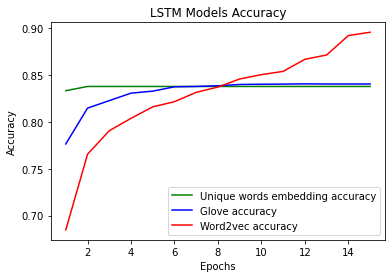

In [179]:
withoutemm = lstm_wemm_hist.history['accuracy']
glove = lstm_glove_hist.history['accuracy']
word2vec = lstm_w2v_hist.history['accuracy']
epochs = range(1,16)
plt.plot(epochs, withoutemm, 'g', label='Unique words embedding accuracy')
plt.plot(epochs, glove, 'b', label='Glove accuracy')
plt.plot(epochs, word2vec, 'r', label='Word2vec accuracy')
plt.title('LSTM Models Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

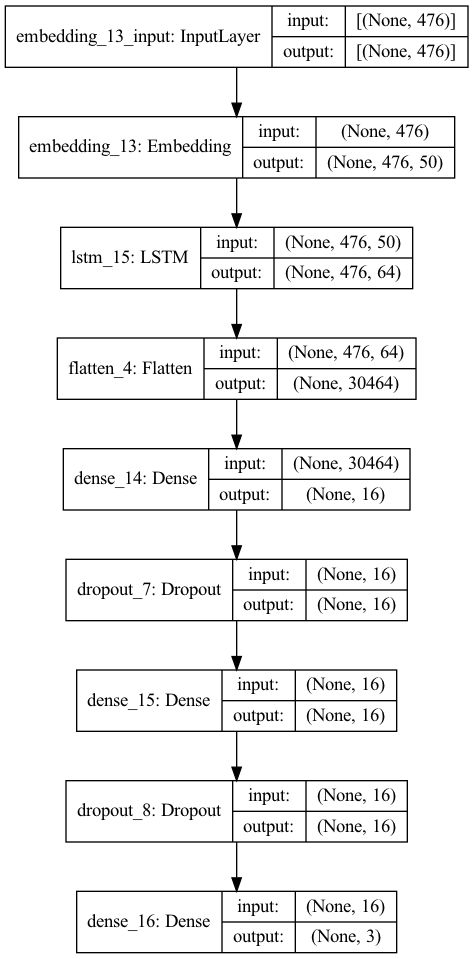

In [180]:
tf.keras.utils.plot_model(model, "multi_input_and_output_model.png", show_shapes=True)